Lecture notes

- Sample size: n
- Predictor dim: p
- Parameter #: d

1. Feature selection
- Best subset selection
    - Evaluate for all k=0...p predictors cases
    - Not practical for large p
- Stepwise selection
    - Forward: add predictor 1by1 to meet the threshold
    - Backword: remove predictor 1by1 to meet the threshold; only valid for n>p
    - Hybrid
    - Not guaranteed to yield the best model
- Choose the optimal model
    - Cp, AIC, BIC: depend on n, d, RSS and the estimate of the variance of epsi
    - Adjusted R^2: depends on RSS, TSS, n, and d
    - Validation and CV (estimate the test error without estimating the variance of epsi)
        - One-standard-error rule
        - Note: must partition the whole sample first before selecting predictors

2. Shrinkage methods
- Ridge regression
    - tuning parameter: lambda
    - minimize (RSS + l2 shrinkage penalty)
    - shrinkage penalty controls the Var(f)
    - better standardizing the predictor first
- Lasso
    - Use l1 norm in shrinkage penalty
    - Note: for sufficiently lage lambda, beta could be exact zero, which is like performing a predictor selection
- Determine tuning parameter
    - Compute CV error for each lambda and choose the one with the smallest error
    - Use the selected lambda to re-fit the model with the full sample
    
3. Dimension reduction methods
- Transform the p predictors to M predictors (components), where M<p
- Principle component analysis (PCA)
    - Only use X, not include Y, to determine components
- Partial least square (PLS)
    - Use both X and Y to determine components
- Use CV to determine the number of components
- Note: PCA/PLS is not predictor selection, as all predictors are used for getting each component    

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets,preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices 

%matplotlib inline

In [6]:
data = pd.read_csv('data/Hitters.csv',header=0)
data = data.dropna().reset_index(drop=True)
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [21]:
# convert categorical data to num
dummy = pd.get_dummies(data[['League','Division','NewLeague']])
dummy.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,0,1,0,1,0,1
1,1,0,0,1,1,0
2,0,1,1,0,0,1
3,0,1,1,0,0,1
4,1,0,0,1,1,0


In [22]:
df = data.drop(['League','Division','NewLeague'],axis=1).astype('float64')
df = pd.concat([df,dummy[['League_N','Division_W','NewLeague_N']]],axis=1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.0,1,1,1
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.0,0,1,0
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.0,1,0,1
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.5,1,0,1
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,750.0,0,1,0


In [26]:
Y = df.Salary
X = df.drop(['Salary'],axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

305.385550883


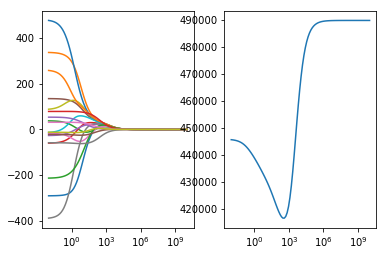

In [135]:
# Ridge
alphas = np.logspace(10,-2,100)
coefs = []
for a in alphas:
    model = Ridge(alpha=a,fit_intercept=False)
    model.fit(X,Y)
    coefs.append(model.coef_)

# CV to determine tuning parameter
modelCV = RidgeCV(alphas=alphas,store_cv_values=True,fit_intercept=False)
modelCV.fit(X,Y)
mse = modelCV.cv_values_.mean(axis=0)
mse.shape = (mse.shape[0],1)
print(modelCV.alpha_)

# Plot
fig, axes = plt.subplots(1,2)
axes[0].plot(alphas,coefs)
axes[0].set_xscale('log')
axes[1].plot(alphas,mse)
axes[1].set_xscale('log')
plt.show()

In [134]:
est.best_params_

{'ridge__alpha': 14.174741629268018}

32.7454916288


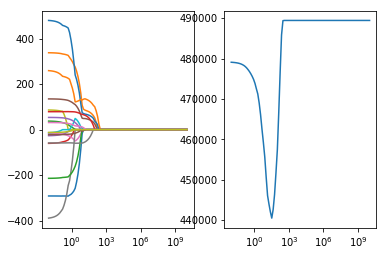

In [77]:
# Lasso
alphas = np.logspace(10,-2,100)
coefs = []
for a in alphas:
    model = Lasso(alpha=a,fit_intercept=False, max_iter=10000)
    model.fit(X,Y)
    coefs.append(model.coef_)

# CV to determine tuning parameter
modelCV = LassoCV(alphas=alphas,fit_intercept=False,cv=5,max_iter=10000)
modelCV.fit(X,Y)
mse = modelCV.mse_path_.mean(axis=1)
mse.shape = (mse.shape[0],1)
print(modelCV.alpha_)    

# Plot
fig, axes = plt.subplots(1,2)
axes[0].plot(alphas,coefs)
axes[0].set_xscale('log')
axes[1].plot(alphas,mse)
axes[1].set_xscale('log')
plt.show()



18
18


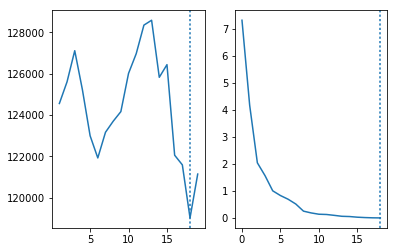

In [171]:
# PCA
pca = PCA()
Xpca = pca.fit_transform(X)

# Use for loop to find the best component num
regr = LinearRegression()
mse = []
for i in np.arange(1, 20):
    pca = PCA(i);
    X_reduced = pca.fit_transform(X)
    score = -1*cross_val_score(regr, X_reduced, Y, cv=5, scoring='neg_mean_squared_error').mean()
    mse.append(score)
print(mse.index(min(mse))+1)

# Use pipeline to find the best component num
model_pipe = make_pipeline(PCA(),LinearRegression())
n=list(np.arange(1,20))
est = GridSearchCV(model_pipe,dict(pca__n_components=n),scoring='neg_mean_squared_error',cv=5)
est.fit(X,Y)
print(est.best_estimator_.named_steps.pca.n_components)

# Plot
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(1, 20),mse)
axes[0].axvline(mse.index(min(mse))+1,linestyle=':')
axes[1].plot(pca.explained_variance_)
axes[1].axvline(est.best_estimator_.named_steps.pca.n_components,linestyle=':')
plt.show()

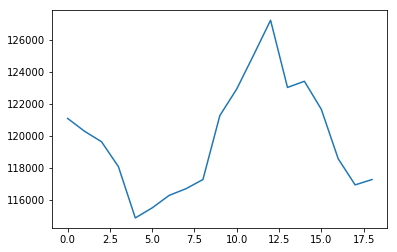

In [152]:
regr = LinearRegression()
mse = []
for i in np.arange(1, 20):
    pca = PCA(i);
    X_reduced = pca.fit_transform(X)
    score = -1*cross_val_score(regr, X_reduced, Y, cv=3, scoring='neg_mean_squared_error').mean()
    mse.append(score)
# Plot
fig, axes = plt.subplots(1,1)
axes.plot(mse)
plt.show()